This notebook peforms Villarubia's blind tip reconstruction from noisy image data

## load required packages and test data

In [20]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Random
using Statistics
using Revise, MDToolbox

In [21]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip surfs images images_randn

## Blind-tip reconstruction from noisy Image

In [22]:
T = [0.1, 1.0, 10.0, 20.0, 50.0, 70.0, 100.0]
loss_over_lambdas_array = []
P_over_lambdas_array = []

nrealization = 10
Random.seed!(777);

for irealization = 1:nrealization
    @info irealization

    for iframe = 1:length(images)
        images_randn[iframe] .= images[iframe] .+ 3.0 .* randn(Float64, size(images[iframe]))
    end

    P_over_lambdas = []
    loss_over_lambdas = []

    for t in T
        m_P = similar(tip)
        m_P .= 0.0

        itip_estimate!(m_P, images_randn[1:100], thresh=t)

        loss = 0.0
        for image in images_randn[1:20]
            loss += mean((idilation(ierosion(image, m_P), m_P) .- image).^2)
        end
        loss = loss / length(images_randn[1:20])
        
        push!(P_over_lambdas, m_P)
        push!(loss_over_lambdas, loss)
    end
    
    push!(P_over_lambdas_array, P_over_lambdas)
    push!(loss_over_lambdas_array, loss_over_lambdas)

end

Processed 100 image
292 refinements 
Processed 100 image
285 refinements 
Processed 100 image
201 refinements 
Processed 100 image
179 refinements 
Processed 100 image
79 refinements 
Processed 100 image
48 refinements 
Processed 100 image
23 refinements 
Processed 100 image
545 refinements 
Processed 100 image
305 refinements 
Processed 100 image
199 refinements 
Processed 100 image
157 refinements 
Processed 100 image
45 refinements 
Processed 100 image
33 refinements 
Processed 100 image
26 refinements 
Processed 100 image
364 refinements 
Processed 100 image
347 refinements 
Processed 100 image
200 refinements 
Processed 100 image
170 refinements 
Processed 100 image
65 refinements 
Processed 100 image
42 refinements 
Processed 100 image
25 refinements 
Processed 100 image
272 refinements 
Processed 100 image
279 refinements 
Processed 100 image
221 refinements 
Processed 100 image
146 refinements 
Processed 100 image
54 refinements 
Processed 100 image
36 refinements 
Processed 10

┌ Info: 1
└ @ Main In[22]:9
┌ Info: 2
└ @ Main In[22]:9
┌ Info: 3
└ @ Main In[22]:9
┌ Info: 4
└ @ Main In[22]:9
┌ Info: 5
└ @ Main In[22]:9
┌ Info: 6
└ @ Main In[22]:9
┌ Info: 7
└ @ Main In[22]:9
┌ Info: 8
└ @ Main In[22]:9
┌ Info: 9
└ @ Main In[22]:9
┌ Info: 10
└ @ Main In[22]:9


In [24]:
gr()

Plots.GRBackend()

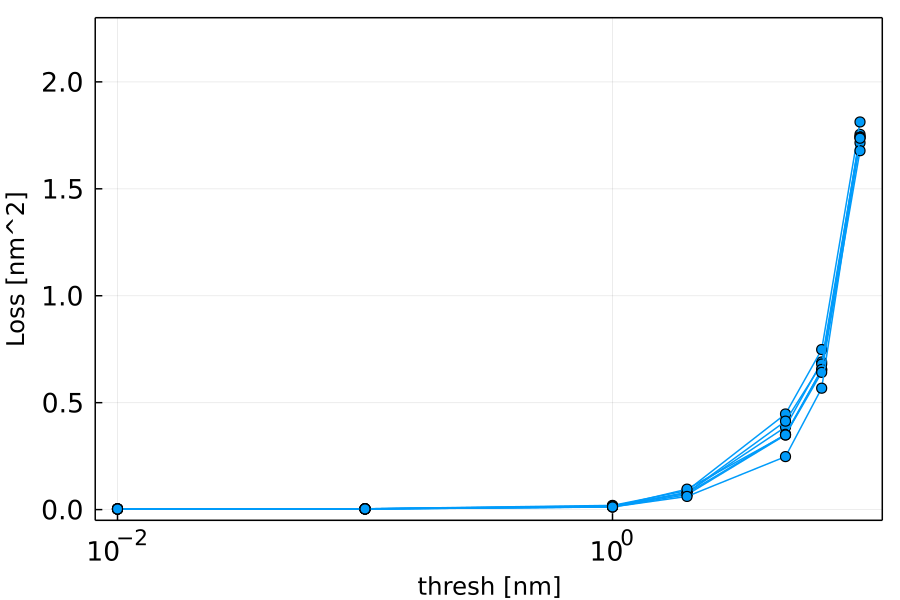

In [100]:
plot(T ./ 10.0, loss_over_lambdas_array[1] / 100.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="loss [nm^2]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
for i = 2:length(T)
    plot!(T ./ 10.0, loss_over_lambdas_array[i] / 100.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="loss [nm^2]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1, 
          xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
end
ylims!(-0.05, 2.3)
xlabel!("thresh [nm]", fontsize=35)
p = ylabel!("Loss [nm^2]", fontsize=35)

In [26]:
savefig(p, "blindtip_original_randn01.png")

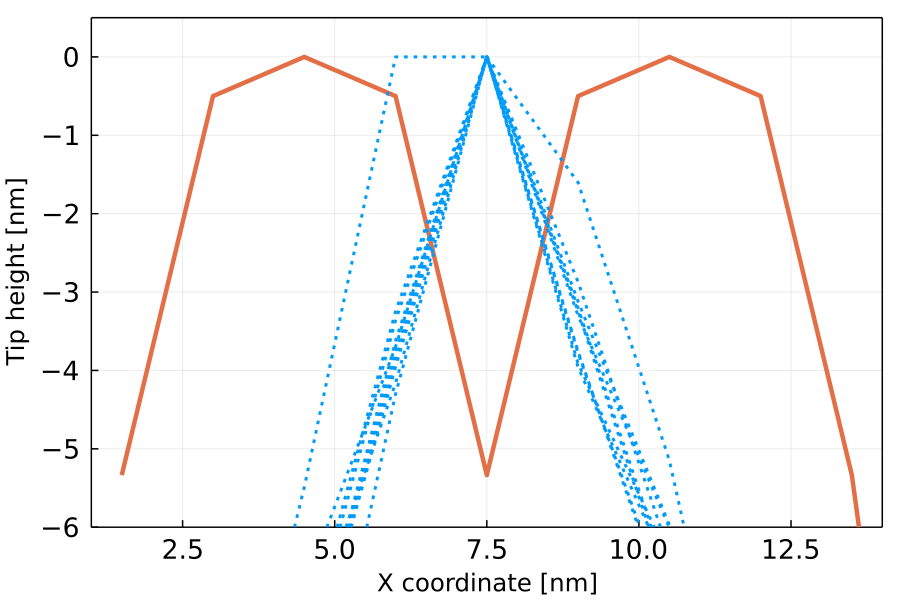

In [102]:
plot(collect(1:11) .* resolution / 10.0, tip[4, :] / 10.0, linewidth=3, label="ground truth", color=2, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
for irealization = 1:nrealization
    if irealization == nrealization
        plot!(collect(1:11) .* resolution / 10.0, P_over_lambdas_array[irealization][4][4, :] / 10.0, linewidth=2, linestyle=:dot, color=1, label="reconstruction", framestyle=:box, dpi=150, fmt=:png)
    else
        plot!(collect(1:11) .* resolution / 10.0, P_over_lambdas_array[irealization][4][4, :] / 10.0, linewidth=2, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
    end
end
ylims!((-6, 0.5))
xlims!((1, 14))
xlabel!("X coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

In [33]:
savefig(p, "blindtip_original_randn02.png")

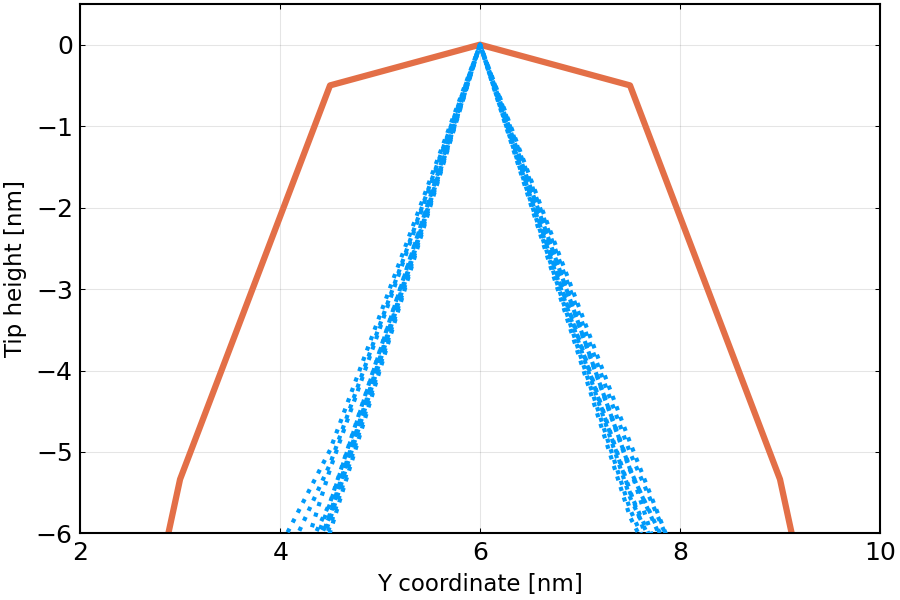

In [68]:
plot(collect(1:9) .* resolution / 10.0, tip[:, 3] / 10.0, linewidth=3, label="ground truth", color=2, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)
for irealization = 1:nrealization
    if irealization == nrealization
        plot!(collect(1:9) .* resolution / 10.0, P_over_lambdas_array[irealization][3][:, 5] / 10.0, linewidth=2, linestyle=:dot, color=1, label="reconstruction", framestyle=:box, dpi=150, fmt=:png)
    else
        plot!(collect(1:9) .* resolution / 10.0, P_over_lambdas_array[irealization][3][:, 5] / 10.0, linewidth=2, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
    end
end
ylims!((-6, 0.5))
xlims!((2, 10))
xlabel!("Y coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

In [69]:
savefig(p, "blindtip_original_randn03.png")

In [70]:
pyplot()

Plots.PyPlotBackend()

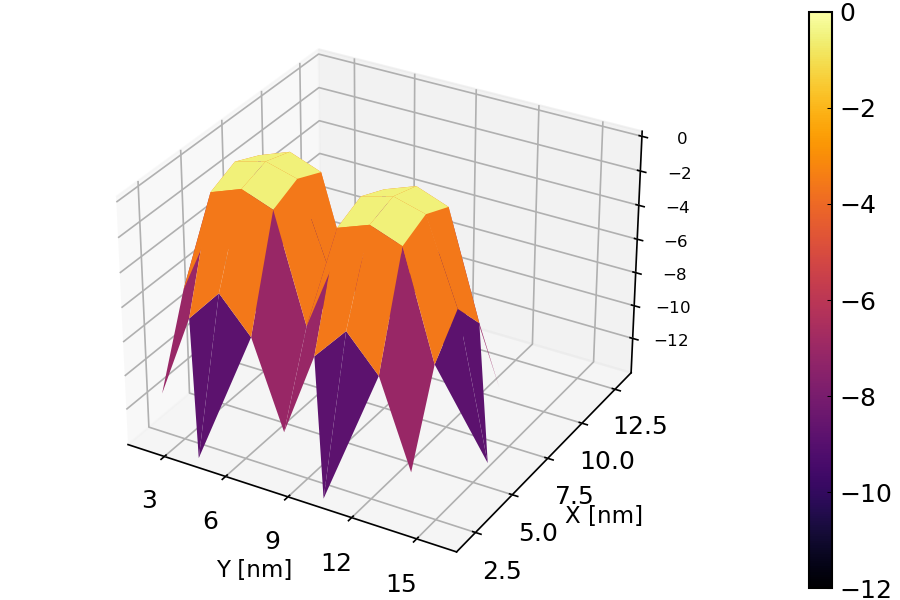

In [71]:
tip_tmp = deepcopy(tip)
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:11) .* resolution ./ 10.0, collect(1:9) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clims=(-12, 0),
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [41]:
savefig(p, "blindtip_original_randn04.png")

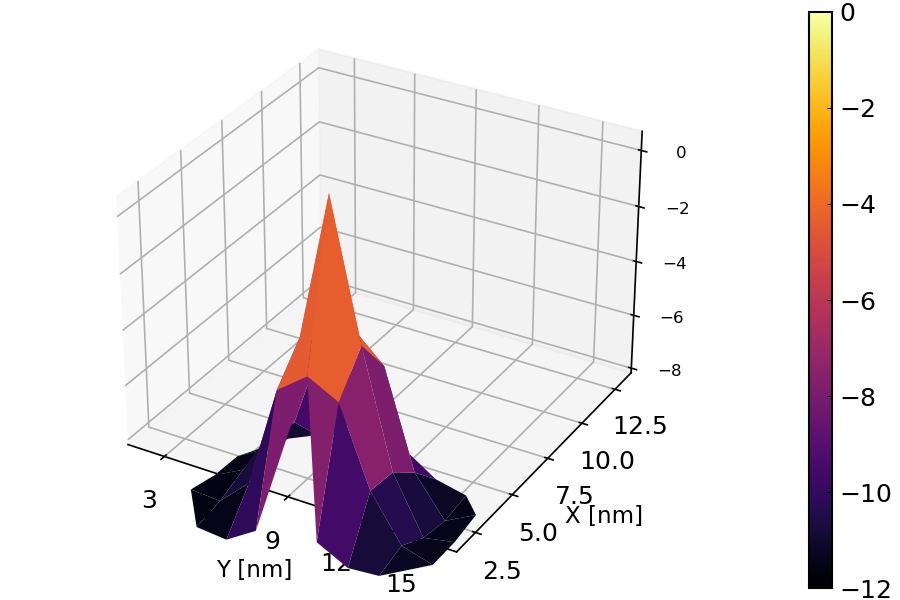

In [43]:
tip_tmp = deepcopy(P_over_lambdas_array[1][3])
tip_tmp[tip .< -100.0] .= NaN

plot(collect(1:11) .* resolution ./ 10.0, collect(1:9) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clims=(-12, 0),
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
zlims!((-8, 0.5))
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Tip height [nm]", fontsize=35)

In [44]:
savefig(p, "blindtip_original_randn05.png")

In [72]:
gr()

Plots.GRBackend()

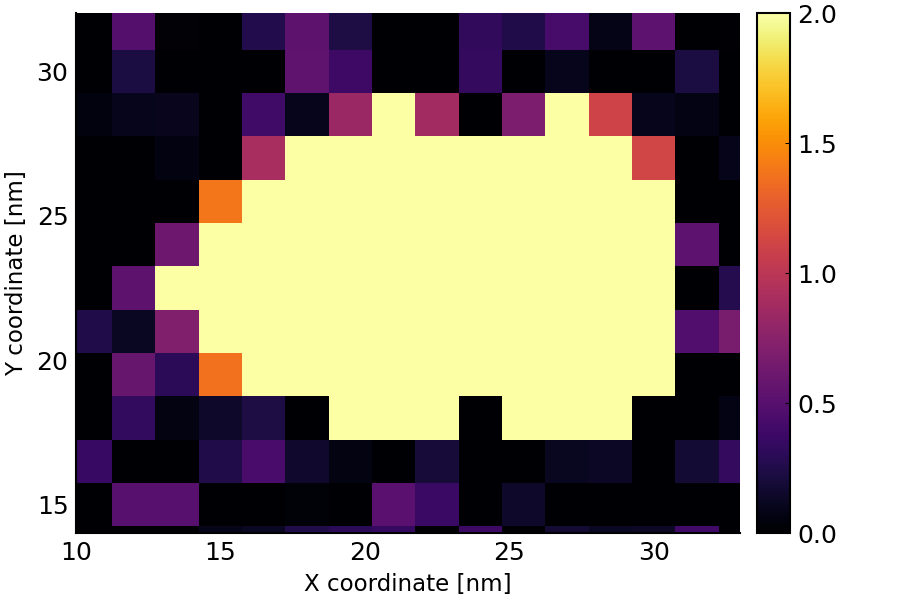

In [54]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, images_randn[1] / 10.0, clim=(0, 2), dpi=150, fmt=:png, 
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 33)
ylims!(14, 32)

In [55]:
savefig(p, "blindtip_original_randn06.png")

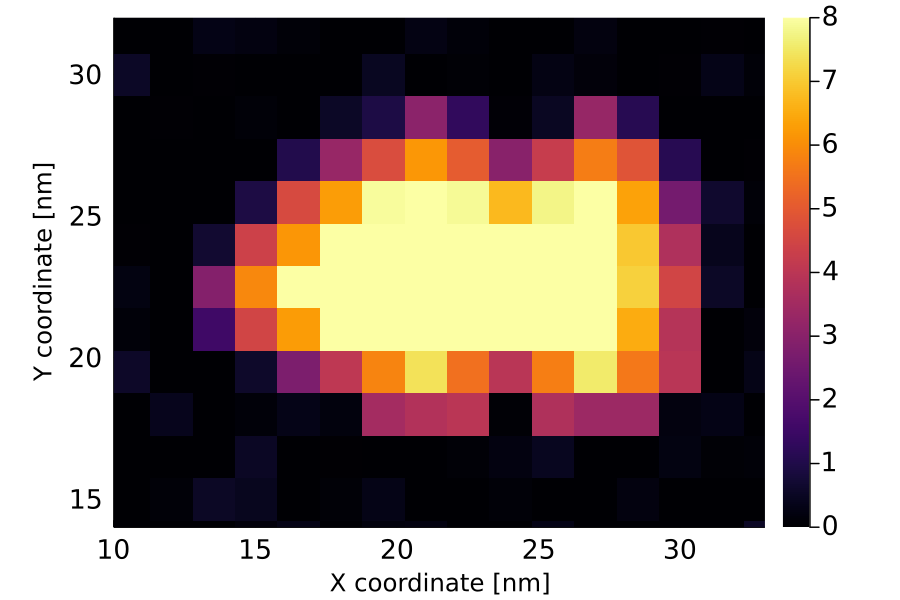

In [120]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(images_randn[1], P_over_lambdas_array[1][4]) / 10.0, clim=(0, 8), dpi=150, fmt=:png, 
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 33)
ylims!(14, 32)

In [60]:
savefig(p, "blindtip_original_randn07.png")

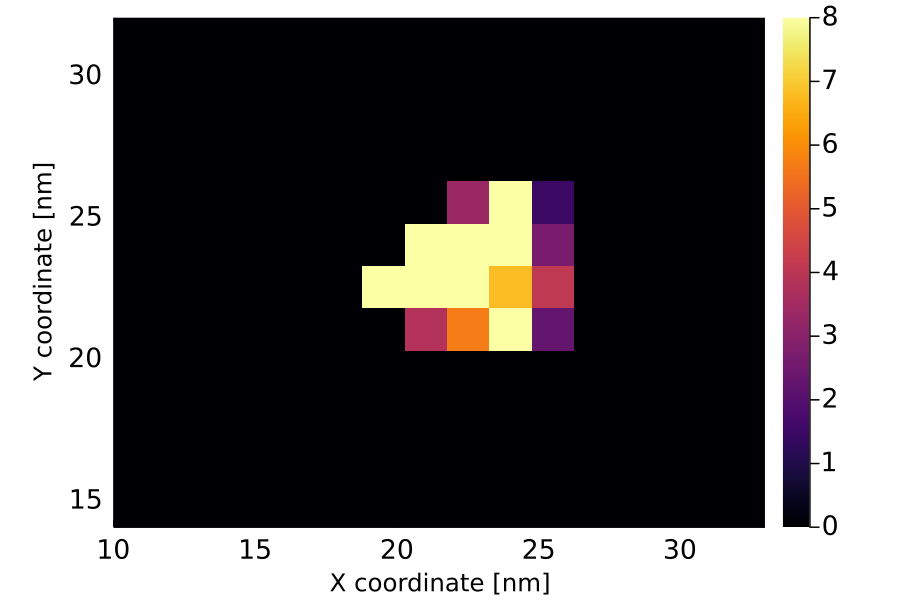

In [73]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, surfs[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png, 
            aspect_ratio=:equal, xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 33)
ylims!(14, 32)

In [74]:
savefig(p, "blindtip_original_randn08.png")

# Correlations

In [133]:
crosscor(image1, image2) = mean((image1 .- mean(image1)) .* (image2 .- mean(image2))) / (std(image1) * std(image2))
#pixel_rmsd(image1, image2) = sqrt(mean((image1 .- image2).^2))

function pixel_rmsd(image1, image2; cutoff = -80.0)
    image1_shifted = similar(image1)

    rmsd_min = Inf64
    for du = -2:2, dv = -2:2
        image1_shifted = circshift(image1, (du, dv))
        id = (image1_shifted .> cutoff) .| (image2 .> cutoff)
        tmp = sqrt(mean((image1_shifted[id] .- image2[id]).^2))
        if tmp < rmsd_min
            rmsd_min = tmp
        end
    end
    return rmsd_min
end

diff_tip = zeros(Float64, length(T)*length(P_over_lambdas_array[:][1]), 2)
count = 0
for it = 1:length(T)
    for ireal = 1:length(P_over_lambdas_array[:][it])
        c = pixel_rmsd(tip, P_over_lambdas_array[ireal][it])
        count += 1
        diff_tip[count, 1] = T[it]
        diff_tip[count, 2] = c
    end
end

In [137]:
gr()

Plots.GRBackend()

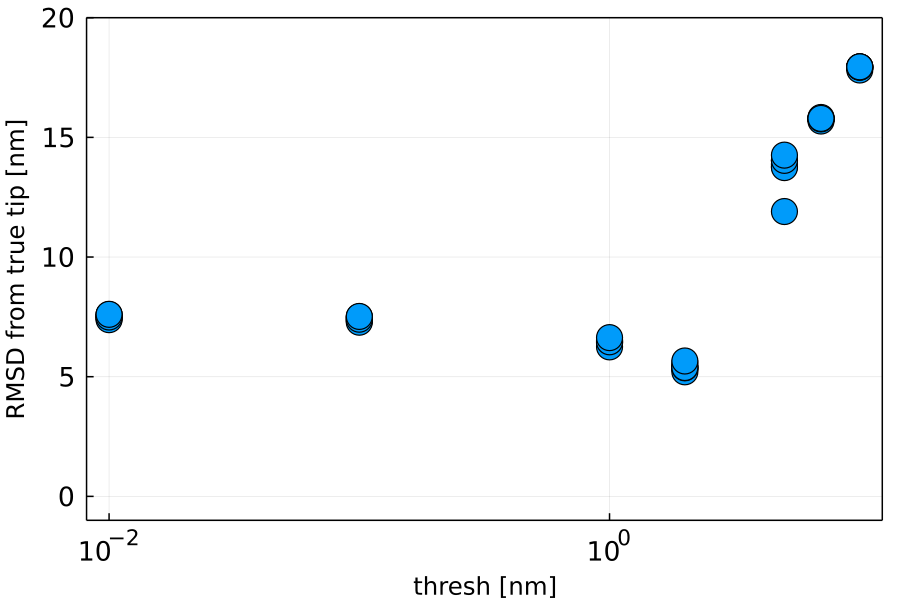

In [139]:
scatter(diff_tip[:, 1] / 10.0, diff_tip[:, 2] / 10.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="RMSD frome true tip [nm]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1, 
        xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12, markersize=10, markerstrokewidth=1)
#ylims!(-0.05, 2.3)
xlabel!("thresh [nm]", fontsize=35)
p = ylabel!("RMSD from true tip [nm]", fontsize=35)
ylims!(-1, 20)

In [140]:
diff_surf = zeros(Float64, length(T)*length(P_over_lambdas_array[:][1])*length(images), 2)
count = 0
Random.seed!(777);
images_randn = deepcopy(images)

function pixel_rmsd(image1, image2; cutoff = 0.0)
    #id = (image1 .> cutoff) .| (image2 .> cutoff)

    rmsd_min = Inf64
    for du = -1:1, dv = -2:2
        image1_shifted = circshift(image1, (du, dv))
        id = (image1 .> cutoff) .| (image2 .> cutoff)
        tmp = sqrt(mean((image1_shifted[id] .- image2[id]).^2))
        if tmp < rmsd_min
            rmsd_min = tmp
        end
    end
    return rmsd_min
end

for it = 1:length(T)
    for ireal = 1:length(P_over_lambdas_array[:][it])
        for iframe = 1:length(images)
            images_randn[iframe] .= images[iframe] .+ 3.0 .* randn(Float64, size(images[iframe]))
            c = pixel_rmsd(surfs[iframe], ierosion(images_randn[iframe], P_over_lambdas_array[ireal][it]))
            count += 1
            diff_surf[count, 1] = T[it]
            diff_surf[count, 2] = c
        end
    end
end

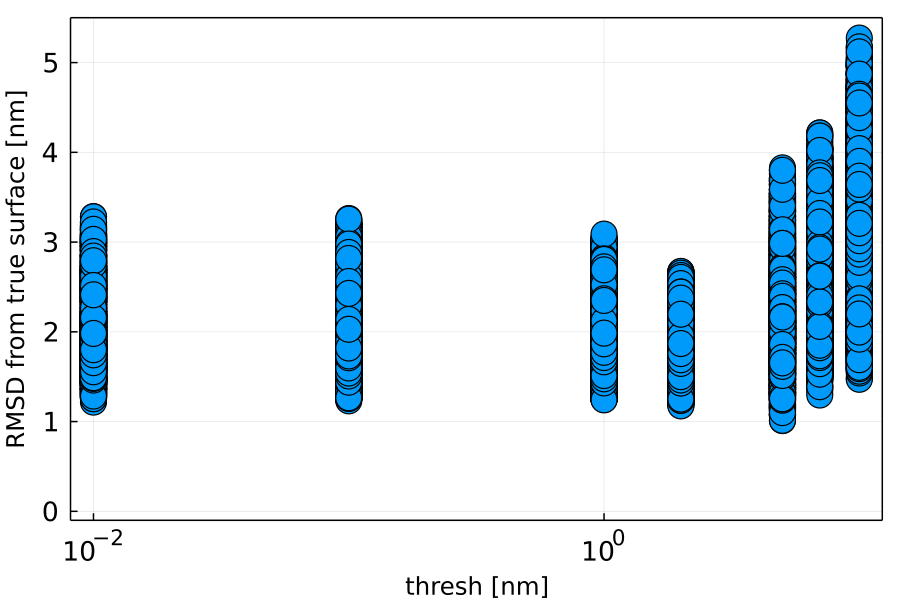

In [141]:
gr()
scatter(diff_surf[:, 1] / 10.0, diff_surf[:, 2] / 10.0, xaxis=:log, framestyle=:box, xlabel="threshold T", ylabel="RMSD frome true tip [nm]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1,
        xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12, markersize=10, markerstrokewidth=1)
#ylims!(-0.05, 2.3)
xlabel!("thresh [nm]", fontsize=35)
p = ylabel!("RMSD from true surface [nm]", fontsize=35)
ylims!(-0.1, 5.5)

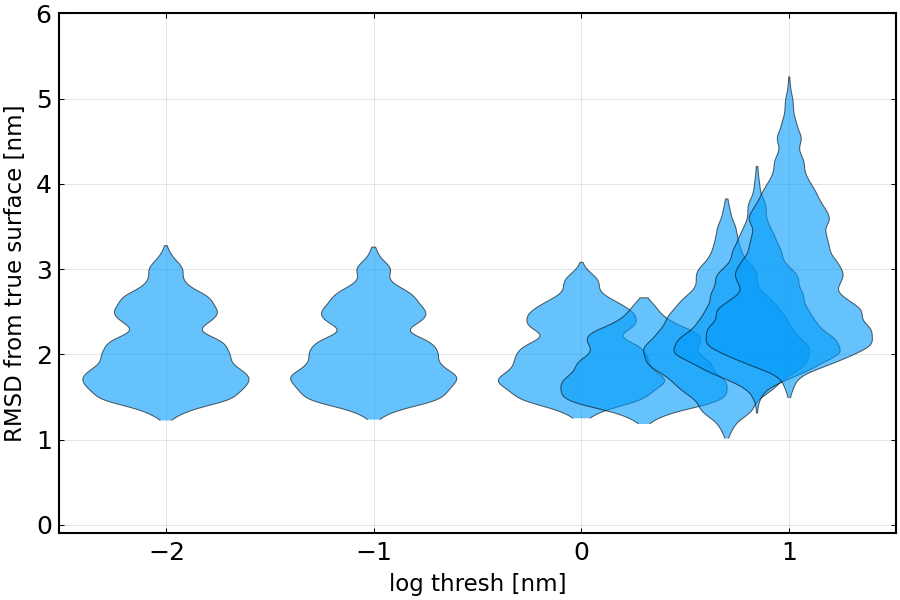

In [142]:
using StatsPlots
pyplot()

violin(log10.(diff_surf[:, 1] / 10.0), diff_surf[:, 2] / 10.0, ylim=(-0.1, 6.0),
       xtickfontsize=12, ytickfontsize=12, legendfontsize=12, 
       xlabel="log thresh [nm]", ylabel="RMSD from true surface [nm]", 
       framestyle=:box, label=nothing, linewidth=0.5, dpi=150, fmt=:png, alpha=0.6, color=1)

#ylims!(-0.1, 4.5)

# Save results

In [143]:
using BSON: @save, @load

@save "blindtip_original_randn.bson" tip T P_over_lambdas_array
@save "blindtip_original_randn_rmsd.bson" diff_tip diff_surf